In [1]:
import tensorflow as tf

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras import optimizers
from pandas import Series
import math
import numpy
from tensorflow.keras.layers import *
from tensorflow.keras import layers
import pandas as pd

data = pd.read_csv("PRSA_data_2010.1.1-2014.12.31.csv")

In [2]:
def gradient_importance(seq, model):

    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(seq)

    grads = tape.gradient(predictions, seq)
    grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grads

def gradient_weight(seq, model):

    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(seq)

    grad = tape.gradient(predictions, seq)
    #gr=grads
    #grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grad

def activation_grad(seq, model):
    
    seq = seq[np.newaxis,:,:]
    grad_model = Model([model.inputs], 
                       [model.get_layer('extractor').output, 
                        model.output])

    # Obtain the predicted value and the intermediate filters
    with tf.GradientTape() as tape:
        seq_outputs, predictions = grad_model(seq)

    # Extract filters and gradients
    output = seq_outputs[0]
    grads = tape.gradient(predictions, seq_outputs)[0]

    # Average gradients spatially
    weights = tf.reduce_mean(grads, axis=0)
    
    # Get a ponderated map of filters according to grad importance
    cam = np.ones(output.shape[0], dtype=np.float32)
    for index, w in enumerate(weights):
        cam += w * output[:, index]

    time = int(seq.shape[1]/output.shape[0])
    cam = zoom(cam.numpy(), time, order=1)
    heatmap = (cam - cam.min())/(cam.max() - cam.min())
    
    return heatmap

In [3]:
data

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0


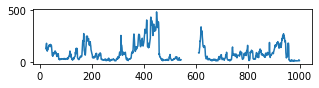

In [4]:
plt.figure(figsize=(5,1))
plt.plot(data['pm2.5'][:1000])

In [4]:
data['cbwd']=data['cbwd'].factorize()[0]

In [5]:
data['pm2.5'] = data['pm2.5'].fillna(method='ffill').fillna(method='bfill')

In [6]:
data

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,129.0,-21,-11.0,1021.0,0,1.79,0,0
1,2,2010,1,1,1,129.0,-21,-12.0,1020.0,0,4.92,0,0
2,3,2010,1,1,2,129.0,-21,-11.0,1019.0,0,6.71,0,0
3,4,2010,1,1,3,129.0,-21,-14.0,1019.0,0,9.84,0,0
4,5,2010,1,1,4,129.0,-20,-12.0,1018.0,0,12.97,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,0,231.97,0,0
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,0,237.78,0,0
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,0,242.70,0,0
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,0,246.72,0,0


In [7]:
data.columns[5:]

Index(['pm2.5', 'DEWP', 'TEMP', 'PRES', 'cbwd', 'Iws', 'Is', 'Ir'], dtype='object')

In [8]:
from sklearn.preprocessing import MinMaxScaler
values = data[data.columns[5:]].values.reshape(-1,8)
values = values.astype('float32')
#scaler = MinMaxScaler(feature_range=(0, 1))
#scaled = scaler.fit_transform(values)
scaled = (values-(np.min(values)))/(np.max(values)-(np.min(values)))

In [9]:
train_size = int(len(scaled) * 0.80)
val_size = int(len(scaled) * 0.10)

test_size = len(scaled) - train_size-val_size
train,val, test,test1 = scaled[0:train_size,:],scaled[train_size:train_size+val_size,:], scaled[train_size+val_size:,:],scaled[train_size:,]
print(len(train),len(val), len(test),len(test1))

35059 4382 4383 8765


In [10]:
def create_dataset_mul(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [11]:
look_back = 24
trainX, trainY = create_dataset_mul(train, look_back)
valX, valY = create_dataset_mul(val, look_back)
testX, testY = create_dataset_mul(test, look_back)
test1X, test1Y = create_dataset_mul(test1, look_back)

35035
4358
4359
8741


In [12]:
print(trainX.shape)
print(trainY.shape)

(35035, 24, 8)
(35035,)


# new

In [40]:
first_input = Input(shape=(24,8))


in0=LSTM(64,return_sequences=True)(first_input)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1])
#ad=MaxPooling1D(pool_size=2)(ad)
#in0=LSTM(64,return_sequences=True)(ad)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1])
#ad1=MaxPooling1D(pool_size=2)(ad1)

#in0=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(ad1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([ad1,in1],name='extractor2')
#in0=Conv1D(filters=64, kernel_size=5, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([in0,in1])

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2, name='extractor')(in1)
in1=Flatten()(in1)
#in1=Dropout(0.5)(in1)
#in1=Dense(100, activation='relu')(in1)
out=Dense(1,'relu')(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

model.summary()

checkpoint_path = "saved_weights/pm2.5_lstmrescnn_onestep_.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 24, 8)]      0                                            
__________________________________________________________________________________________________
lstm_9 (LSTM)                   (None, 24, 64)       18688       input_10[0][0]                   
__________________________________________________________________________________________________
conv1d_39 (Conv1D)              (None, 24, 64)       12352       lstm_9[0][0]                     
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 24, 64)       8256        conv1d_39[0][0]                  
______________________________________________________________________________________

In [79]:
hist = model.fit([trainX],trainY, epochs = 130,validation_data=([valX],valY),batch_size=100, verbose = 1,callbacks=[cb])

Epoch 1/130
349/351 [============================>.] - ETA: 0s - loss: 0.0018
Epoch 00001: val_loss improved from inf to 0.00070, saving model to saved_weights\pm2.5_lstmrescnn_onestep_.hdf5
351/351 [==============================] - 8s 21ms/step - loss: 0.0018 - val_loss: 7.0218e-04
Epoch 2/130
349/351 [============================>.] - ETA: 0s - loss: 6.6971e-04
Epoch 00002: val_loss did not improve from 0.00070
351/351 [==============================] - 7s 21ms/step - loss: 6.6869e-04 - val_loss: 8.5988e-04
Epoch 3/130
351/351 [==============================] - ETA: 0s - loss: 5.2177e-04
Epoch 00003: val_loss improved from 0.00070 to 0.00051, saving model to saved_weights\pm2.5_lstmrescnn_onestep_.hdf5
351/351 [==============================] - 8s 22ms/step - loss: 5.2177e-04 - val_loss: 5.0809e-04
Epoch 4/130
349/351 [============================>.] - ETA: 0s - loss: 5.0535e-04
Epoch 00004: val_loss did not improve from 0.00051
351/351 [==============================] - 9s 24ms/ste

KeyboardInterrupt: 

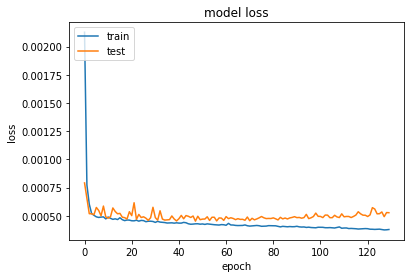

In [49]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

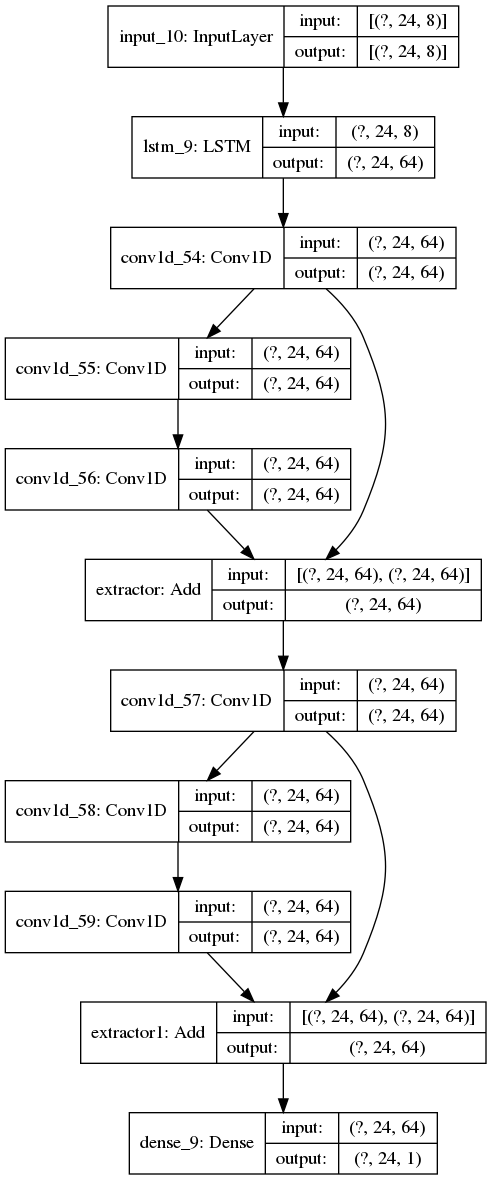

In [62]:
from IPython.display import SVG
from tensorflow.keras.utils import plot_model
%matplotlib inline
dot_img_file = './model_1.png'

plot_model(model, to_file=dot_img_file, show_shapes=True)


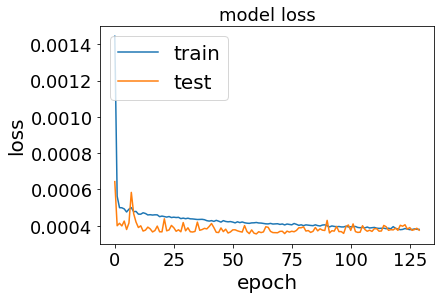

In [418]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [38]:
model.load_weights('saved_weights/pm2.5_lstmcnn_onestep.hdf5')

(1, 24, 8)


<Figure size 1080x5040 with 0 Axes>

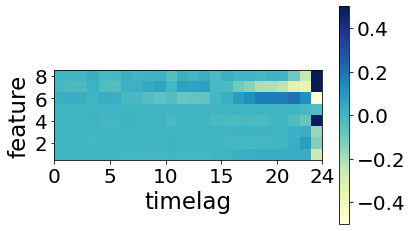

In [39]:
import matplotlib.pyplot as plt
import numpy as np

X_test=testX

grad_weight = gradient_weight(X_test[4], model)

#grad_weight=grad_weight.reshape(48,4)

print(grad_weight.shape)
plt.figure(figsize=(15,70))

#plt.plot(X_test[8], 'k')
a=grad_weight.numpy()
a=a.reshape(24,8)
a=a.transpose()

#print(a)
fig, ax = plt.subplots(1,1)

extent = [0 , 24, 0 , 8]
y_label_list = [2,4,6,8]
x_label_list = [0,5,10,15,20,24]
ax.set_xticks([0,5,10,15,20,24])

ax.set_yticks([1.5,3.5,5.5,7.5])

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)
ax.set_ylabel('feature')
ax.set_xlabel('timelag')

plt.imshow(a,extent = [0 , 24, 0 , 8], vmin=-0.5, vmax=0.5, cmap="YlGnBu", interpolation='nearest')
plt.colorbar()

plt.show()

In [41]:
model.load_weights('saved_weights/pm2.5_lstmrescnn_onestep_.hdf5')

(1, 24, 8)


<Figure size 1080x5040 with 0 Axes>

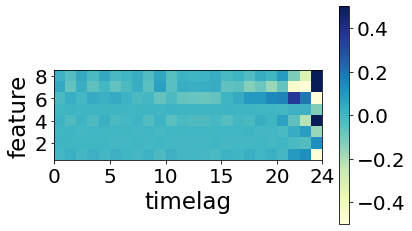

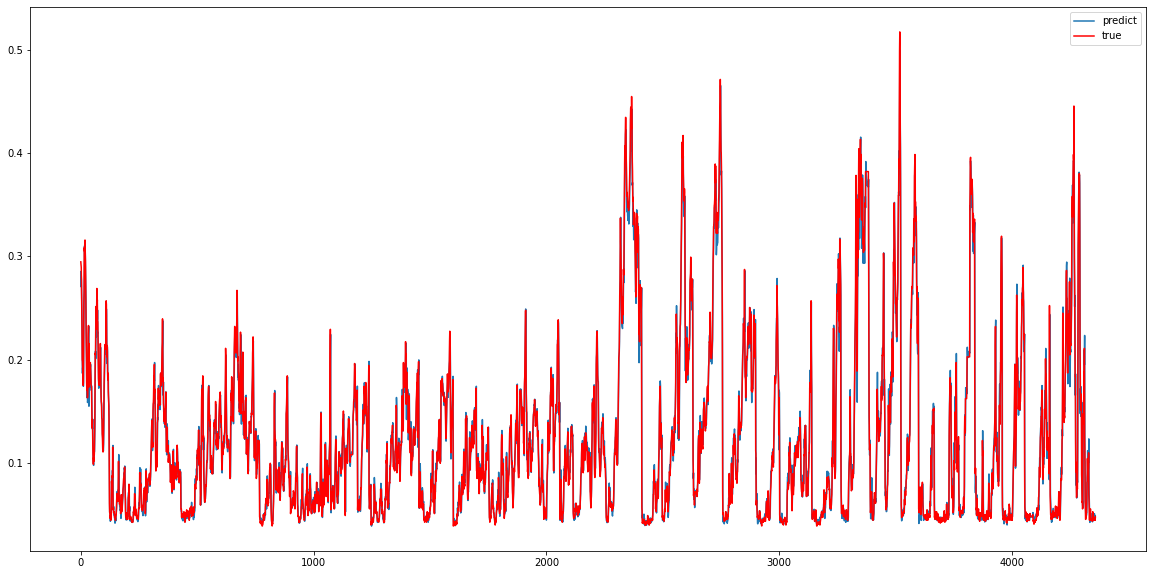

Test RMSE: 0.01614
Test MAE: 0.00951
Test MSE: 0.00026
Test MAPE: 0.08687
Test RMSE: 17.53317
Test MAE: 10.32936
Test MAPE: 0.21511


In [19]:

from sklearn.metrics import *

from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY,'r', label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)



yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(np.array(yhat_inverse), testY_inverse))
mae=mean_absolute_error(np.array(yhat_inverse), testY_inverse)
mape=mean_absolute_percentage_error(testY_inverse,np.array(yhat_inverse))

print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)
print('Test MAPE: %.5f' % mape)

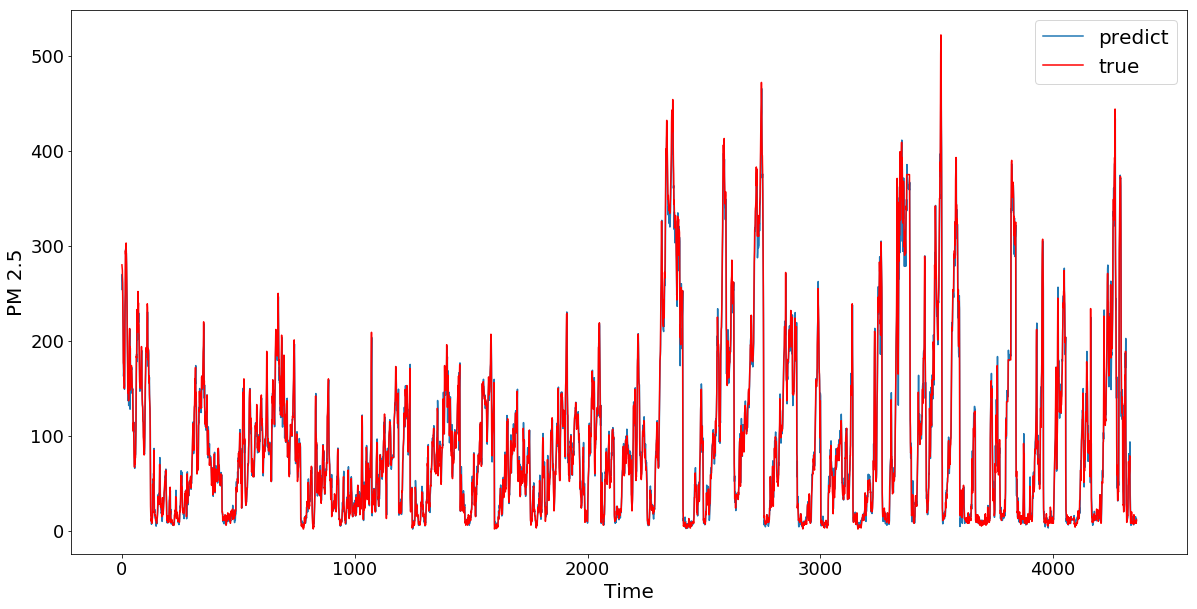

In [38]:
plt.figure(figsize=(20,10))
SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE) # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE) # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE) # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE) # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE) # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE) # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE) # fontsize of the figure title
pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse,'r', label='true')
pyplot.legend()

plt.ylabel('PM 2.5')
plt.xlabel('Time')

pyplot.show()

In [71]:
model.load_weights('saved_weights/pm2.5_lstmrescnn_onestep_maxpool.hdf5')

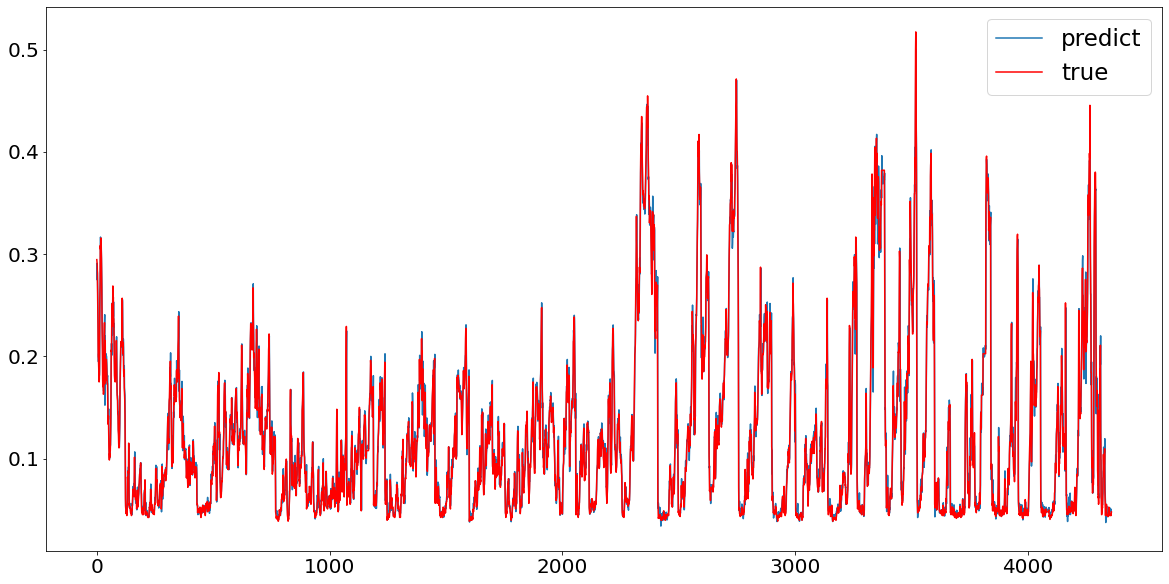

Test RMSE: 0.01619
Test MAE: 0.00948
Test MSE: 0.00026
Test MAPE: 0.08793
Test RMSE: 17.58530
Test MAE: 10.29920
Test MAPE: 0.22478


In [81]:

from sklearn.metrics import *

from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY,'r', label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)



yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(np.array(yhat_inverse), testY_inverse))
mae=mean_absolute_error(np.array(yhat_inverse), testY_inverse)
mape=mean_absolute_percentage_error(testY_inverse,np.array(yhat_inverse))

print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)
print('Test MAPE: %.5f' % mape)

In [93]:
model.load_weights('saved_weights/pm2.5_lstmrescnn_onestep.hdf5')

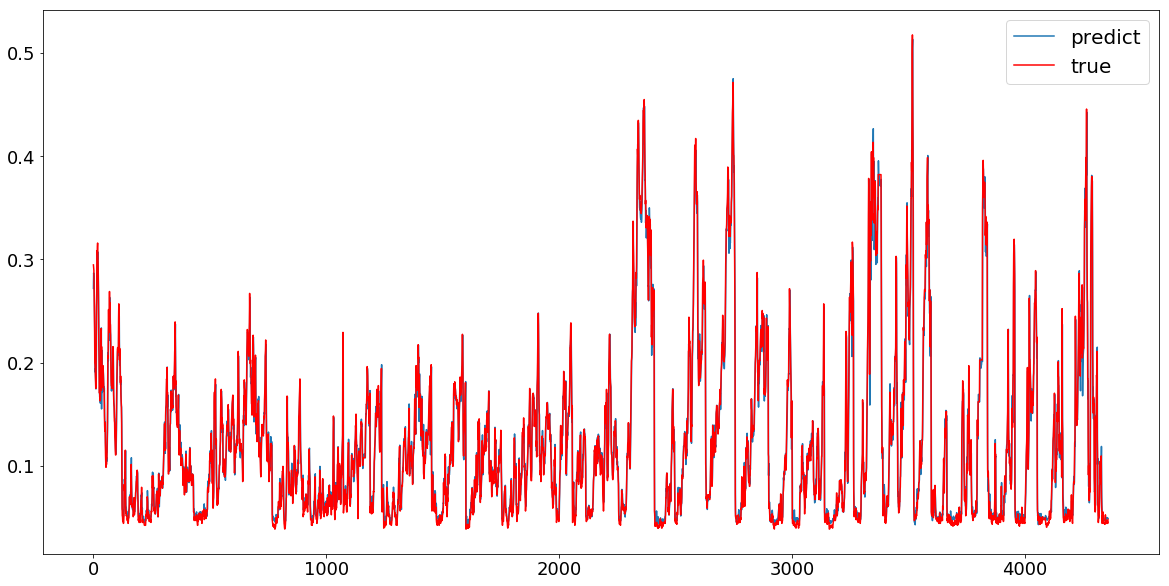

Test RMSE: 0.01619
Test MAE: 0.00961
Test MSE: 0.00026
Test RMSE: 17.58256
Test MAE: 10.44060
Test MSE: 309.14642


In [45]:
from sklearn.metrics import *

from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY,'r', label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
mae=mean_absolute_error(yhat_inverse, testY_inverse)
mse=mean_squared_error(yhat_inverse, testY_inverse)
print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)
print('Test MSE: %.5f' % mse)

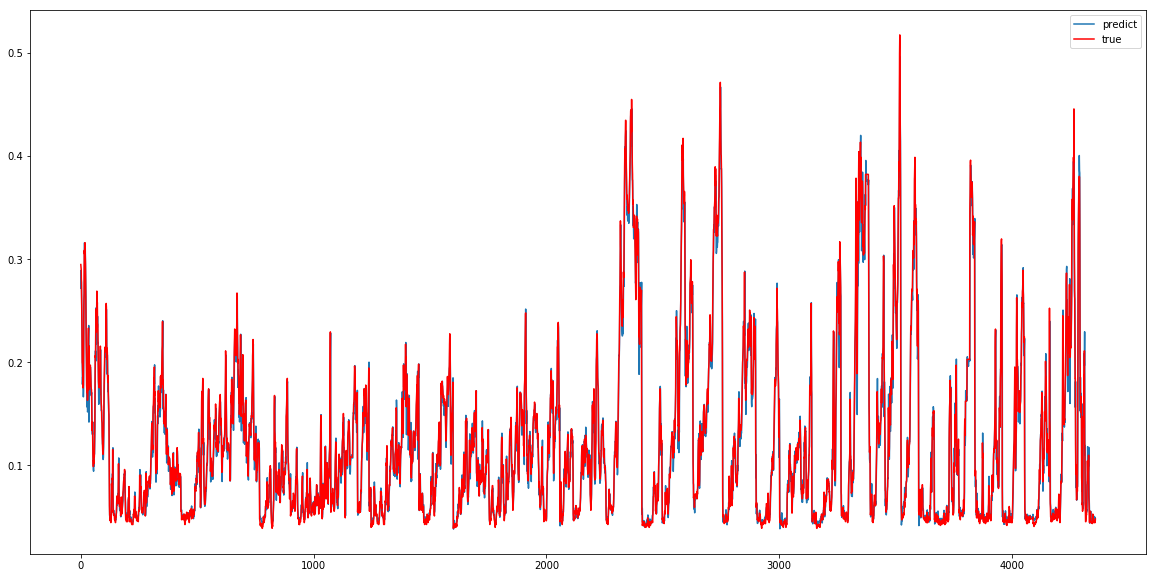

Test RMSE: 0.01629
Test MAE: 0.00958
Test MSE: 0.00027
Test RMSE: 17.69187
Test MAE: 10.40597


In [322]:
from sklearn.metrics import *

from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY,'r', label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
mae=mean_absolute_error(yhat_inverse, testY_inverse)
print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)


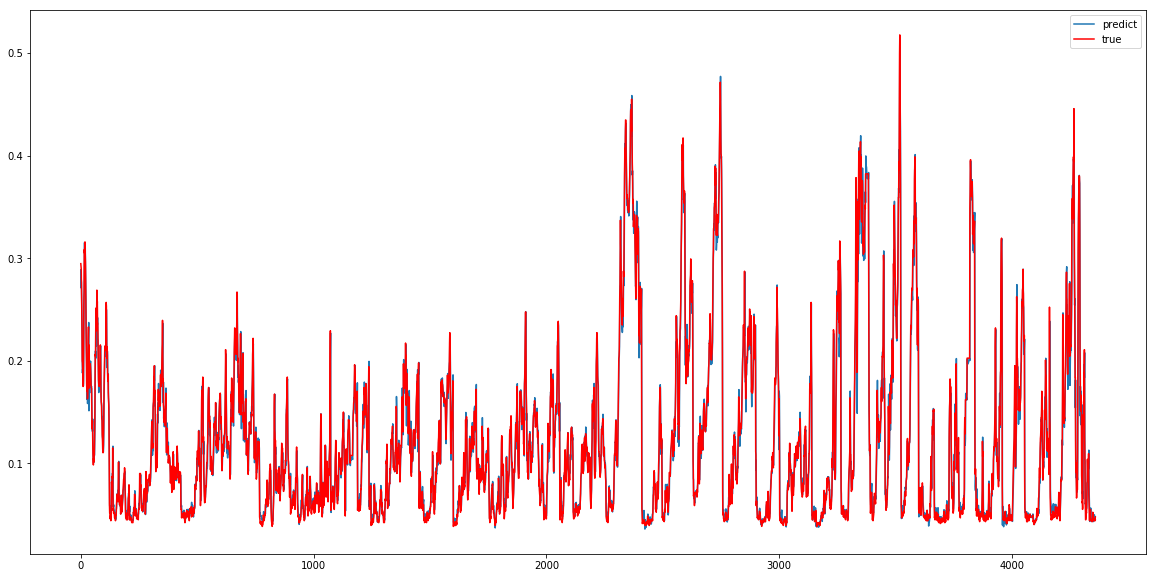

Test RMSE: 0.01629
Test MAE: 0.00961
Test MSE: 0.00027
Test RMSE: 17.69346
Test MAE: 10.44088


In [274]:
from sklearn.metrics import *

from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY,'r', label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
mae=mean_absolute_error(yhat_inverse, testY_inverse)
print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)


In [14]:
SMALL_SIZE = 20
MEDIUM_SIZE = 23
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE) # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE) # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE) # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE) # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE) # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE) # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE) # fontsize of the figure title

In [91]:
id_=24*8
X_test=testX.copy()

testX_inverse=X_test[id_][:,0]*(np.max(values)-np.min(values))+np.min(values)
testX_inverse

array([28., 28., 25., 15., 17., 18., 35., 17., 17., 18., 24., 28., 31.,
       40., 42., 48., 52., 53., 58., 58., 64., 61., 41., 35.],
      dtype=float32)

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


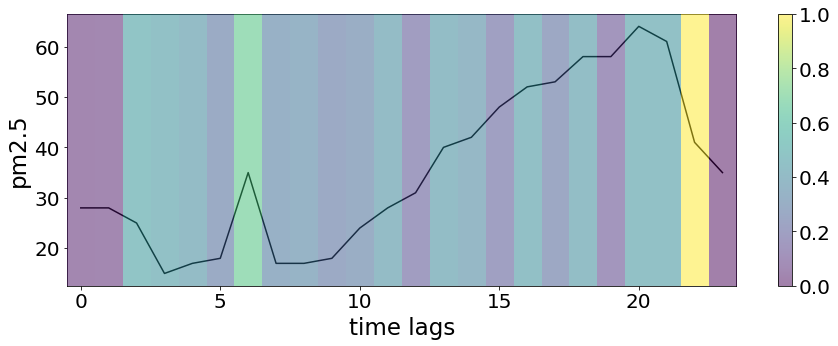

In [75]:
from tensorflow.keras.models import Model
from scipy.ndimage import zoom
import random
import pylab



X_test=testX.copy()
activation = activation_grad(X_test[id_], model)
print(activation)
plt.figure(figsize=(15,5))

plt.plot(testX_inverse, 'k')
#plt.plot(X_test[id_])
#plt.plot(yhat, label='predict')
#plt.plot(testY, label='true')
plt.ylabel('pm2.5'); plt.xlabel('time lags'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
plt.twinx()
#plt.xticks(a)
plt.imshow(np.vstack([activation]*120), alpha=0.5, cmap='viridis')
plt.axis('off'); plt.colorbar()
plt.axis('off')
#pylab.pcolor(np.vstack([activation]*120),cmap='jet',alpha=0.35)

#pylab.colorbar()

np.set_printoptions(False)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


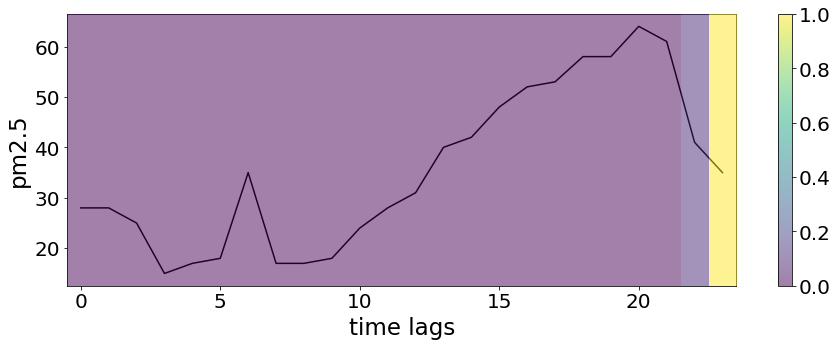

In [94]:
from tensorflow.keras.models import Model
from scipy.ndimage import zoom
import random
import pylab



X_test=testX.copy()
activation = activation_grad(X_test[id_], model)
print(activation)
plt.figure(figsize=(15,5))

plt.plot(testX_inverse, 'k')
#plt.plot(X_test[id_])
#plt.plot(yhat, label='predict')
#plt.plot(testY, label='true')
plt.ylabel('pm2.5'); plt.xlabel('time lags'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
plt.twinx()
#plt.xticks(a)
plt.imshow(np.vstack([activation]*120), alpha=0.5, cmap='viridis')
plt.axis('off'); plt.colorbar()
plt.axis('off')
#pylab.pcolor(np.vstack([activation]*120),cmap='jet',alpha=0.35)

#pylab.colorbar()

np.set_printoptions(False)

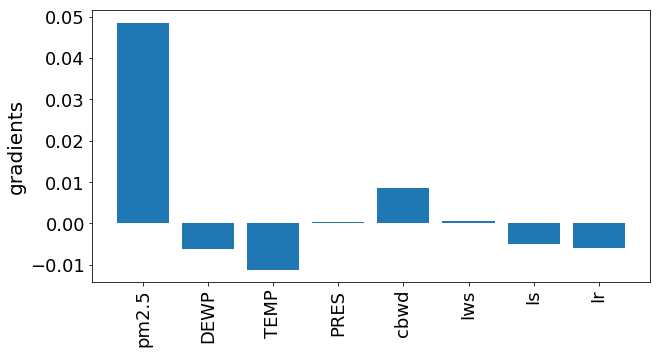

In [34]:

columns=data.columns[5:]
X_test=testX.copy()

grad_imp = gradient_importance(X_test[id_], model)

plt.figure(figsize=(10,5))
plt.bar(range(len(grad_imp)), grad_imp)
plt.xticks(range(len(columns)), columns, rotation=90)
plt.ylabel('gradients'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
np.set_printoptions(False)

[0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


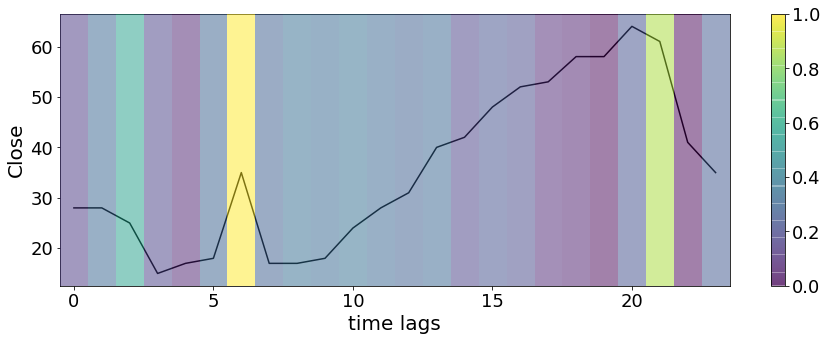

In [32]:
from tensorflow.keras.models import Model
from scipy.ndimage import zoom
import random
import pylab



X_test=testX.copy()
activation = activation_grad(X_test[id_], model)
print(activation)
plt.figure(figsize=(15,5))

plt.plot(testX_inverse, 'k')
#plt.plot(X_test[id_])
#plt.plot(yhat, label='predict')
#plt.plot(testY, label='true')
plt.ylabel('Close'); plt.xlabel('time lags'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
plt.twinx()
#plt.xticks(a)
plt.imshow(np.vstack([activation]*120), alpha=0.5, cmap='viridis')
plt.axis('off'); plt.colorbar()
plt.axis('off')
#pylab.pcolor(np.vstack([activation]*120),cmap='jet',alpha=0.35)

#pylab.colorbar()

np.set_printoptions(False)

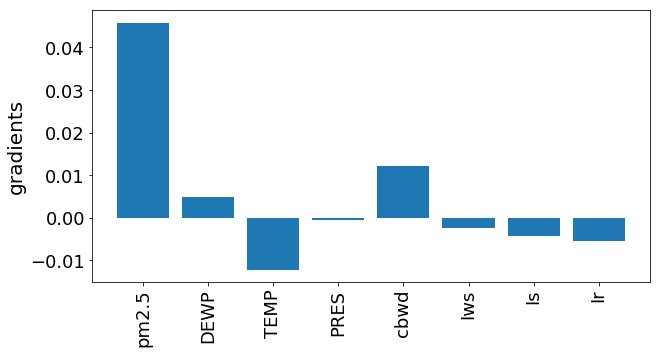

In [40]:

columns=data.columns[5:]
X_test=testX.copy()

grad_imp = gradient_importance(X_test[id_], model)

plt.figure(figsize=(10,5))
plt.bar(range(len(grad_imp)), grad_imp)
plt.xticks(range(len(columns)), columns, rotation=90)
plt.ylabel('gradients'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
np.set_printoptions(False)

(1, 24, 8)


<Figure size 1080x5040 with 0 Axes>

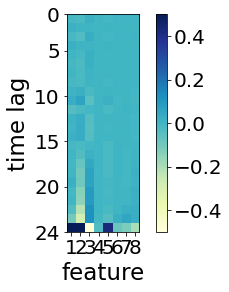

In [20]:
####lstm-cnn

import matplotlib.pyplot as plt
import numpy as np

X_test=testX
grad_weight = gradient_weight(X_test[55], model)

#grad_weight=grad_weight.reshape(48,4)

print(grad_weight.shape)
plt.figure(figsize=(15,70))

#plt.plot(X_test[8], 'k')
a=grad_weight.numpy()
a=a.reshape(24,8)

#print(a)
fig, ax = plt.subplots(1,1)

extent = [0 , 8, 0 , 24]
x_label_list = [1,2,3,4,5,6,7,8,9]
y_label_list = [24,20,15,10,5,0]
ax.set_yticks([0,5,10,15,20,24])

ax.set_xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5])

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)
ax.set_ylabel('time lag')
ax.set_xlabel('feature')

plt.imshow(a,extent = [0 , 8, 0 , 24], vmin=-0.5, vmax=0.5, cmap="YlGnBu", interpolation='nearest')
plt.colorbar()

plt.show()


(1, 24, 8)


<Figure size 1080x5040 with 0 Axes>

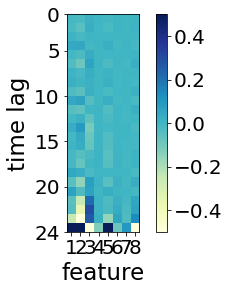

In [17]:
##residual

import matplotlib.pyplot as plt
import numpy as np

X_test=testX
grad_weight = gradient_weight(X_test[55], model)

#grad_weight=grad_weight.reshape(48,4)

print(grad_weight.shape)
plt.figure(figsize=(15,70))

#plt.plot(X_test[8], 'k')
a=grad_weight.numpy()
a=a.reshape(24,8)

#print(a)
fig, ax = plt.subplots(1,1)

extent = [0 , 8, 0 , 24]
x_label_list = [1,2,3,4,5,6,7,8,9]
y_label_list = [24,20,15,10,5,0]
ax.set_yticks([0,5,10,15,20,24])

ax.set_xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5])

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)
ax.set_ylabel('time lag')
ax.set_xlabel('feature')

plt.imshow(a,extent = [0 , 8, 0 , 24], vmin=-0.5, vmax=0.5, cmap="YlGnBu", interpolation='nearest')
plt.colorbar()

plt.show()


### CNN-LSTM

In [26]:
first_input = Input(shape=(24,8))

in0=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
in0=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2,name='extractor')(in1)

#in1=add([in0,in1])
#in1=Flatten()(in1)
#in1=Dense(50, activation='relu')(in1)
in1=LSTM(64)(in1)

out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "saved_weights/pm2.5_cnnlstm_onestep.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
model.summary()
# fit model9
#history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 24, 8)]           0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 24, 64)            1088      
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 24, 64)            8256      
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 24, 64)            4160      
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 24, 64)            8256      
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 24, 64)            8256      
_________________________________________________________________
extractor (Conv1D)           (None, 24, 64)          

KeyboardInterrupt: 

In [190]:
model.summary()

Model: "model_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 24, 11)]          0         
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 24, 64)            3584      
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 24, 64)            12352     
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 24, 64)            4160      
_________________________________________________________________
extractor (MaxPooling1D)     (None, 12, 64)            0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 150)               129000    
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 151

In [27]:
model.load_weights("saved_weights/pm2.5_cnnlstm_onestep.hdf5")

(1, 24, 8)


<Figure size 1080x5040 with 0 Axes>

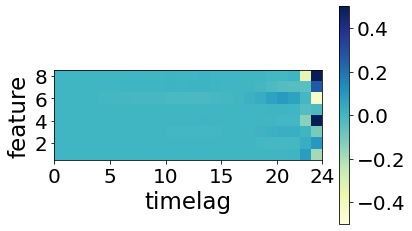

In [31]:
import matplotlib.pyplot as plt
import numpy as np

X_test=testX

grad_weight = gradient_weight(X_test[4], model)

#grad_weight=grad_weight.reshape(48,4)

print(grad_weight.shape)
plt.figure(figsize=(15,70))

#plt.plot(X_test[8], 'k')
a=grad_weight.numpy()
a=a.reshape(24,8)
a=a.transpose()

#print(a)
fig, ax = plt.subplots(1,1)

extent = [0 , 24, 0 , 8]
y_label_list = [2,4,6,8]
x_label_list = [0,5,10,15,20,24]
ax.set_xticks([0,5,10,15,20,24])

ax.set_yticks([1.5,3.5,5.5,7.5])

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)
ax.set_ylabel('feature')
ax.set_xlabel('timelag')

plt.imshow(a,extent = [0 , 24, 0 , 8], vmin=-0.5, vmax=0.5, cmap="YlGnBu", interpolation='nearest')
plt.colorbar()

plt.show()

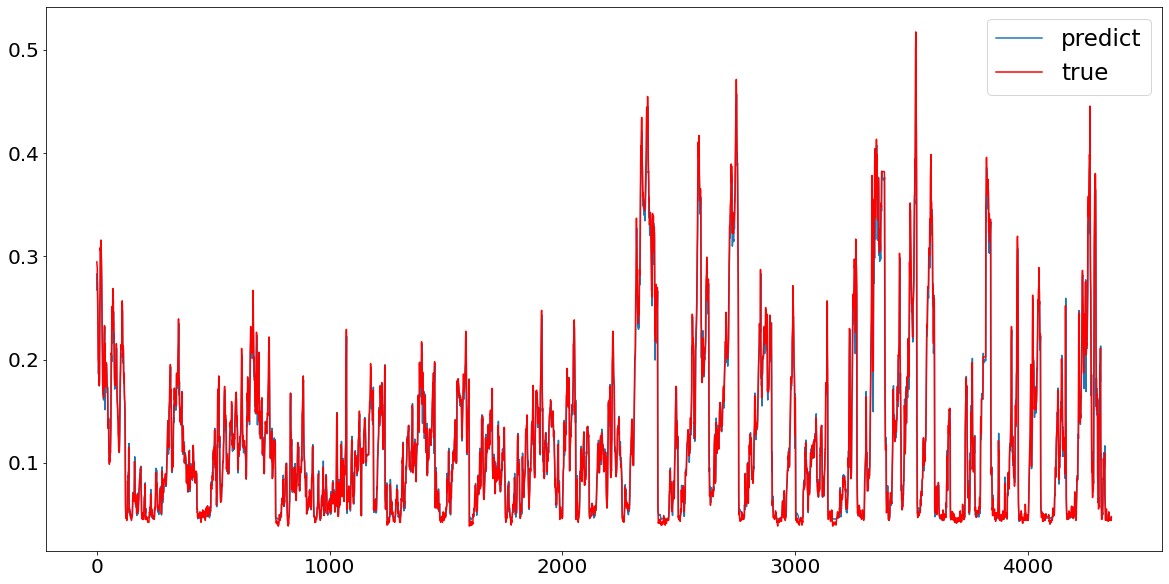

Test RMSE: 0.01662
Test MAE: 0.00980
Test MSE: 0.00028
Test MAPE: 0.08873
Test RMSE: 18.04405
Test MAE: 10.64059
Test MAPE: 0.23012


In [115]:
#1dcnn(5,1)-lstm

from sklearn.metrics import *

from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY,'r', label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)



yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(np.array(yhat_inverse), testY_inverse))
mae=mean_absolute_error(np.array(yhat_inverse), testY_inverse)
mape=mean_absolute_percentage_error(testY_inverse,np.array(yhat_inverse))

print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)
print('Test MAPE: %.5f' % mape)


In [183]:
id_=100
X_test=testX.copy()
testX_inverse=X_test[id_][:,0]*(np.max(values)-np.min(values))+np.min(values)
testX_inverse

array([157.     , 153.     , 153.     , 149.99998, 158.     , 168.     ,
       167.     , 184.     , 194.     , 181.     , 153.     , 139.     ,
       133.     , 130.     , 116.     , 114.     ,  99.     ,  94.     ,
        84.     ,  80.     ,  80.     ,  88.     , 103.     , 132.     ],
      dtype=float32)

In [178]:
len(activation)

24

[1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1.]


(-0.5, 23.5, 119.5, -0.5)

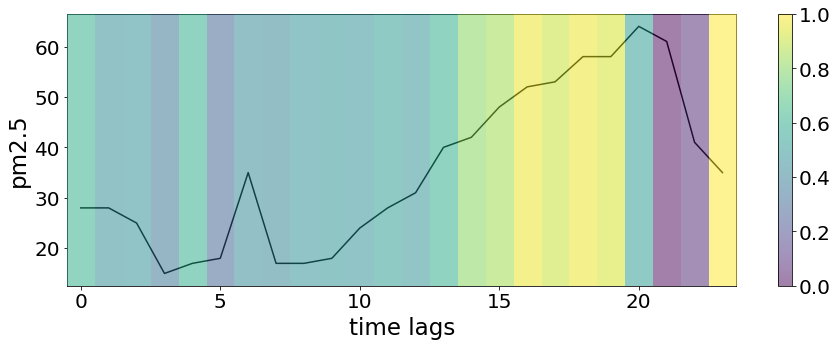

In [116]:
from scipy.ndimage import zoom
import random
import pylab




X_test=testX.copy()
activation = activation_grad(X_test[id_], model)
print(activation)
plt.figure(figsize=(15,5))
label=[0,5,10,15,20]
plt.xticks(np.arange(0,24,5),label)

plt.plot(testX_inverse, 'k')
#plt.plot(X_test[id_])
#plt.plot(yhat, label='predict')
#plt.plot(testY, label='true')
plt.ylabel('pm2.5'); plt.xlabel('time lags'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
plt.twinx()
#plt.xticks(a)
plt.imshow(np.vstack([activation]*120), alpha=0.5, cmap='viridis')
plt.axis('off'); plt.colorbar()
plt.axis('off')

### LSTM-CNN

In [34]:
from tensorflow.keras.models import Model

first_input = Input(shape=(24,8))

in1=LSTM(units =150 , return_sequences=True)(first_input)

#in1=TimeDistributed(Conv1D(filters=64, kernel_size=2, activation='relu'))(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=Conv1D(filters=64, kernel_size=3, activation='relu')(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=Conv1D(filters=64, kernel_size=2, activation='relu')(in1)

in1=Conv1D(filters=64, kernel_size=1, activation='relu')(in1)

#in1=add([in0,in1],name='extractor')
in1=MaxPooling1D(pool_size=2,name='extractor')(in1)

in1=Flatten()(in1)
#model.add(LSTM(units = 128, return_sequences=True))
#in1=LSTM(units =50 , return_sequences=False)(in1)
#lstm_out=Bidirectional(LSTM(units =100 , return_sequences=False))(lstm_out)

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1, in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2)(in1)

#flat_out = Flatten()(in1)
#flat_out=Dense(20, activation='relu')(flat_out)
#model.add(Dropout(drop_dense))
out1=Dense(1, activation = 'relu')(in1)
model=Model(inputs=first_input, outputs=out1)
model.compile(optimizer='adam', loss='mse')


In [25]:
model.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 24, 11)]          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 24, 150)           97200     
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 22, 64)            28864     
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 21, 64)            8256      
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 21, 64)            4160      
_________________________________________________________________
extractor (MaxPooling1D)     (None, 10, 64)            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 640)              

In [35]:
checkpoint_path = "saved_weights/pm2.5_lstmcnn_150_5_1_.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

In [36]:
history=model.fit(trainX, trainY, epochs=150, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Epoch 1/150
351/351 [==============================] - ETA: 0s - loss: 0.0028
Epoch 00001: val_loss improved from inf to 0.00171, saving model to saved_weights\pm2.5_lstmcnn_150_5_1_.hdf5
351/351 [==============================] - 55s 156ms/step - loss: 0.0028 - val_loss: 0.0017
Epoch 2/150
185/351 [==============>...............] - ETA: 26s - loss: 0.0016

KeyboardInterrupt: 

In [33]:
model.load_weights("saved_weights/pm2.5_lstmcnn_150_5_1_.hdf5")


ValueError: You are trying to load a weight file containing 4 layers into a model with 5 layers.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

X_test=testX

grad_weight = gradient_weight(X_test[4], model)

#grad_weight=grad_weight.reshape(48,4)

print(grad_weight.shape)
plt.figure(figsize=(15,70))

#plt.plot(X_test[8], 'k')
a=grad_weight.numpy()
a=a.reshape(24,8)
a=a.transpose()

#print(a)
fig, ax = plt.subplots(1,1)

extent = [0 , 24, 0 , 8]
y_label_list = [2,4,6,8]
x_label_list = [0,5,10,15,20,24]
ax.set_xticks([0,5,10,15,20,24])

ax.set_yticks([1.5,3.5,5.5,7.5])

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)
ax.set_ylabel('feature')
ax.set_xlabel('timelag')

plt.imshow(a,extent = [0 , 24, 0 , 8], vmin=-0.5, vmax=0.5, cmap="YlGnBu", interpolation='nearest')
plt.colorbar()

plt.show()

In [211]:
id_=105
X_test=testX.copy()
testX_inverse=X_test[id_][:,0]*(np.max(values)-np.min(values))+np.min(values)
testX_inverse

array([168.     , 167.     , 184.     , 194.     , 181.     , 153.     ,
       139.     , 133.     , 130.     , 116.     , 114.     ,  99.     ,
        94.     ,  84.     ,  80.     ,  80.     ,  88.     , 103.     ,
       132.     , 151.     , 164.99998, 182.     , 191.     , 193.     ],
      dtype=float32)

In [212]:
len(testX_inverse)

24

[0.8685908  0.68548745 0.5023841  0.3292737  0.15741241 0.10340023
 0.08305408 0.06079823 0.03758152 0.01752363 0.         0.00607742
 0.04168919 0.13596128 0.34759006 0.5524928  0.73386663 0.9006234
 0.95031166 1.        ]


(-0.5, 19.5, 119.5, -0.5)

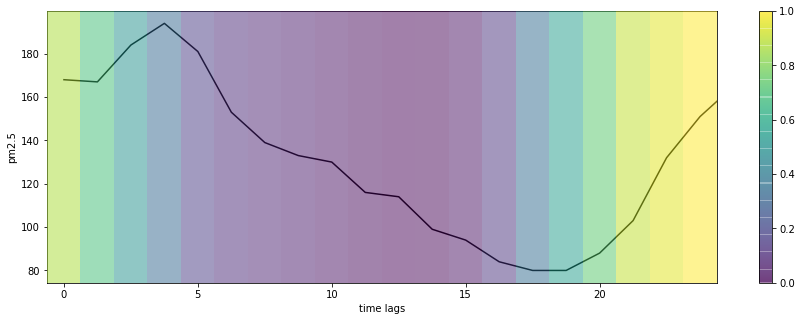

In [213]:
from scipy.ndimage import zoom
import random
import pylab




X_test=testX.copy()
activation = activation_grad(X_test[id_], model)
print(activation)
plt.figure(figsize=(15,5))
label=[0,5,10,15,20]
plt.xticks(np.arange(0,20,4),label)

plt.plot(testX_inverse, 'k')
#plt.plot(X_test[id_])
#plt.plot(yhat, label='predict')
#plt.plot(testY, label='true')
plt.ylabel('pm2.5'); plt.xlabel('time lags'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
plt.twinx()
#plt.xticks(a)
plt.imshow(np.vstack([activation]*120), alpha=0.5, cmap='viridis')
plt.axis('off'); plt.colorbar()
plt.axis('off')

In [214]:
len(activation)

20

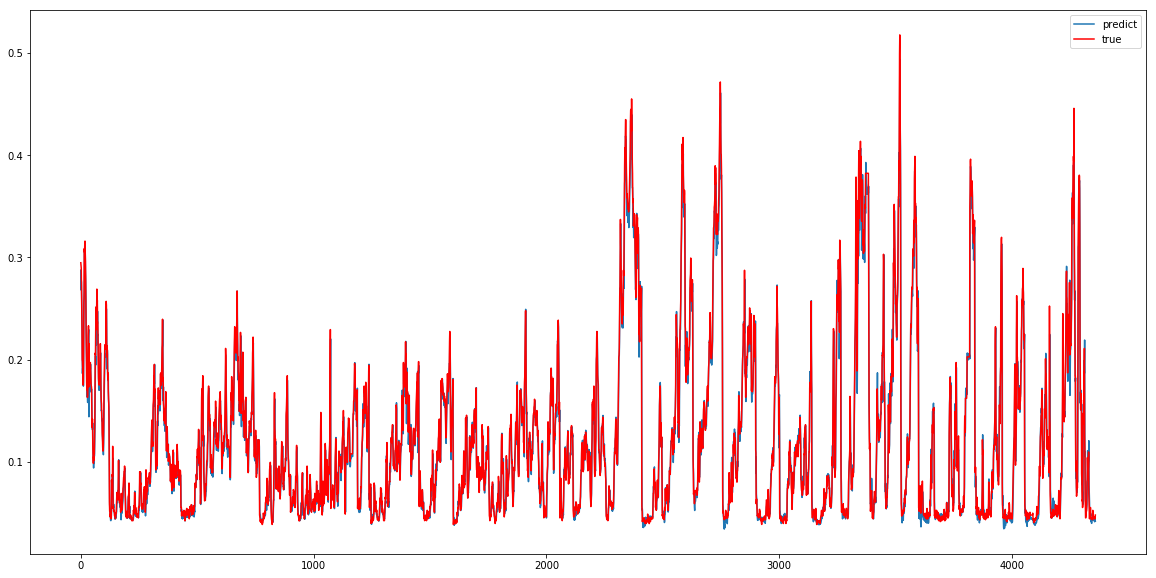

Test RMSE: 0.01650
Test MAE: 0.00999
Test MSE: 0.00027
Test RMSE: 17.91722
Test MAE: 10.84912


In [130]:
from sklearn.metrics import *
from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)

plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY,'r', label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)


rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(yhat_inverse, testY_inverse)
print('Test MAE: %.5f' % mae)

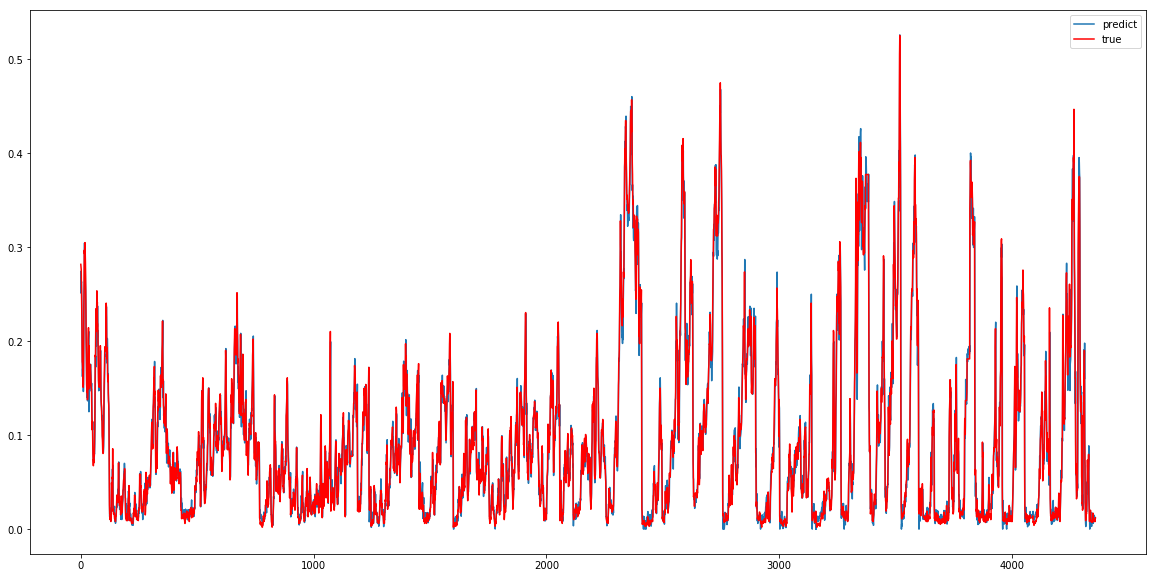

Test RMSE: 0.01789
Test MAE: 0.01100
Test MSE: 0.00032
Test RMSE: 19.43214
Test MAE: 11.94186


In [27]:
from sklearn.metrics import *
from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)

plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY,'r', label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)


rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(yhat_inverse, testY_inverse)
print('Test MAE: %.5f' % mae)

### Timedistributed 1d-CNN

In [679]:
from tensorflow.keras.models import *

first_input = Input(shape=(None,24,11))

in1=TimeDistributed(Conv1D(filters=64, kernel_size=5, activation='relu'))(first_input)
#in1= BatchNormalization(scale=False)(in1)
#in0=TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'))(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'))(in1)

#in1=add([in0,in1],name='extractor')
in1=TimeDistributed(MaxPooling1D(pool_size=2,name='extractor'))(in1)

in1=TimeDistributed(Flatten())(in1)
#model.add(LSTM(units = 128, return_sequences=True))
#in1=LSTM(units =50 , return_sequences=False)(in1)
#lstm_out=Bidirectional(LSTM(units =100 , return_sequences=False))(lstm_out)

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1, in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2)(in1)

#flat_out = Flatten()(in1)
#flat_out=Dense(20, activation='relu')(flat_out)
#model.add(Dropout(drop_dense))
out1=Dense(1, activation = 'relu')(in1)
model=Model(inputs=first_input, outputs=out1)
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "saved_weights/pm2.5_conv1d_timedist_5_1.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

# fit model9
history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Train on 35035 samples, validate on 4358 samples
Epoch 1/200
34400/35035 [============================>.] - ETA: 0s - loss: 0.0030
Epoch 00001: val_loss improved from inf to 0.00202, saving model to saved_weights/pm2.5_conv1d_timedist_5_1.hdf5
35035/35035 [==============================] - 1s 35us/sample - loss: 0.0029 - val_loss: 0.0020
Epoch 2/200
34300/35035 [============================>.] - ETA: 0s - loss: 0.0012
Epoch 00002: val_loss improved from 0.00202 to 0.00123, saving model to saved_weights/pm2.5_conv1d_timedist_5_1.hdf5
35035/35035 [==============================] - 1s 25us/sample - loss: 0.0012 - val_loss: 0.0012
Epoch 3/200
34400/35035 [============================>.] - ETA: 0s - loss: 9.6360e-04
Epoch 00003: val_loss improved from 0.00123 to 0.00104, saving model to saved_weights/pm2.5_conv1d_timedist_5_1.hdf5
35035/35035 [==============================] - 1s 25us/sample - loss: 9.6201e-04 - val_loss: 0.0010
Epoch 4/200
34000/35035 [============================>.] - ETA

Epoch 32/200
34500/35035 [============================>.] - ETA: 0s - loss: 5.3011e-04
Epoch 00032: val_loss did not improve from 0.00069
35035/35035 [==============================] - 1s 24us/sample - loss: 5.2925e-04 - val_loss: 7.2059e-04
Epoch 33/200
34500/35035 [============================>.] - ETA: 0s - loss: 5.1520e-04
Epoch 00033: val_loss did not improve from 0.00069
35035/35035 [==============================] - 1s 24us/sample - loss: 5.1646e-04 - val_loss: 7.3549e-04
Epoch 34/200
34000/35035 [============================>.] - ETA: 0s - loss: 5.1373e-04
Epoch 00034: val_loss did not improve from 0.00069
35035/35035 [==============================] - 1s 25us/sample - loss: 5.1170e-04 - val_loss: 7.2406e-04
Epoch 35/200
33900/35035 [============================>.] - ETA: 0s - loss: 5.1254e-04
Epoch 00035: val_loss did not improve from 0.00069
35035/35035 [==============================] - 1s 25us/sample - loss: 5.1184e-04 - val_loss: 8.1158e-04
Epoch 36/200
34400/35035 [======

34500/35035 [============================>.] - ETA: 0s - loss: 4.4295e-04
Epoch 00065: val_loss did not improve from 0.00068
35035/35035 [==============================] - 1s 24us/sample - loss: 4.4406e-04 - val_loss: 7.6006e-04
Epoch 66/200
34600/35035 [============================>.] - ETA: 0s - loss: 4.3488e-04
Epoch 00066: val_loss did not improve from 0.00068
35035/35035 [==============================] - 1s 24us/sample - loss: 4.3481e-04 - val_loss: 7.6768e-04
Epoch 67/200
34300/35035 [============================>.] - ETA: 0s - loss: 4.3774e-04
Epoch 00067: val_loss did not improve from 0.00068
35035/35035 [==============================] - 1s 24us/sample - loss: 4.3886e-04 - val_loss: 7.5026e-04
Epoch 68/200
33900/35035 [============================>.] - ETA: 0s - loss: 4.4765e-04
Epoch 00068: val_loss did not improve from 0.00068
35035/35035 [==============================] - 1s 25us/sample - loss: 4.4836e-04 - val_loss: 6.8948e-04
Epoch 69/200
34100/35035 [===================

Epoch 99/200
34200/35035 [============================>.] - ETA: 0s - loss: 3.9989e-04
Epoch 00099: val_loss did not improve from 0.00068
35035/35035 [==============================] - 1s 25us/sample - loss: 4.0052e-04 - val_loss: 7.0351e-04
Epoch 100/200
34600/35035 [============================>.] - ETA: 0s - loss: 4.0167e-04
Epoch 00100: val_loss did not improve from 0.00068
35035/35035 [==============================] - 1s 26us/sample - loss: 4.0348e-04 - val_loss: 7.3525e-04
Epoch 101/200
34300/35035 [============================>.] - ETA: 0s - loss: 4.1197e-04
Epoch 00101: val_loss did not improve from 0.00068
35035/35035 [==============================] - 1s 24us/sample - loss: 4.1116e-04 - val_loss: 7.0708e-04
Epoch 102/200
34500/35035 [============================>.] - ETA: 0s - loss: 3.9827e-04
Epoch 00102: val_loss did not improve from 0.00068
35035/35035 [==============================] - 1s 24us/sample - loss: 3.9846e-04 - val_loss: 7.1734e-04
Epoch 103/200
34600/35035 [==

Epoch 133/200
34600/35035 [============================>.] - ETA: 0s - loss: 3.8315e-04
Epoch 00133: val_loss did not improve from 0.00068
35035/35035 [==============================] - 1s 24us/sample - loss: 3.8324e-04 - val_loss: 7.7266e-04
Epoch 134/200
34400/35035 [============================>.] - ETA: 0s - loss: 3.7876e-04
Epoch 00134: val_loss did not improve from 0.00068
35035/35035 [==============================] - 1s 24us/sample - loss: 3.7870e-04 - val_loss: 7.4638e-04
Epoch 135/200
34500/35035 [============================>.] - ETA: 0s - loss: 3.9303e-04
Epoch 00135: val_loss did not improve from 0.00068
35035/35035 [==============================] - 1s 24us/sample - loss: 3.9337e-04 - val_loss: 8.0256e-04
Epoch 136/200
34500/35035 [============================>.] - ETA: 0s - loss: 3.8116e-04
Epoch 00136: val_loss did not improve from 0.00068
35035/35035 [==============================] - 1s 24us/sample - loss: 3.8110e-04 - val_loss: 7.5633e-04
Epoch 137/200
34100/35035 [=

Epoch 167/200
34400/35035 [============================>.] - ETA: 0s - loss: 3.5805e-04
Epoch 00167: val_loss did not improve from 0.00068
35035/35035 [==============================] - 1s 24us/sample - loss: 3.5848e-04 - val_loss: 8.0800e-04
Epoch 168/200
34300/35035 [============================>.] - ETA: 0s - loss: 3.6413e-04
Epoch 00168: val_loss did not improve from 0.00068
35035/35035 [==============================] - 1s 24us/sample - loss: 3.6435e-04 - val_loss: 8.4778e-04
Epoch 169/200
34500/35035 [============================>.] - ETA: 0s - loss: 3.6824e-04
Epoch 00169: val_loss did not improve from 0.00068
35035/35035 [==============================] - 1s 24us/sample - loss: 3.6742e-04 - val_loss: 8.0005e-04
Epoch 170/200
34400/35035 [============================>.] - ETA: 0s - loss: 3.8417e-04
Epoch 00170: val_loss did not improve from 0.00068
35035/35035 [==============================] - 1s 24us/sample - loss: 3.8616e-04 - val_loss: 7.8910e-04
Epoch 171/200
34500/35035 [=

In [676]:
model.load_weights("saved_weights/pm2.5_conv1d_5_1.hdf5")

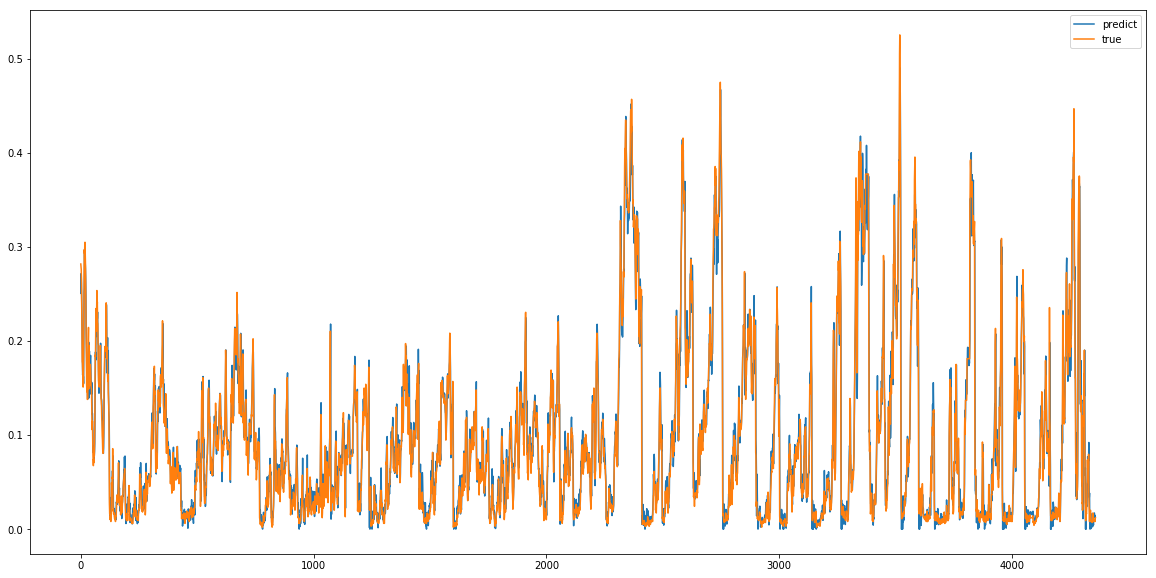

Test RMSE: 0.01964
Test MAE: 0.01262
Test MSE: 0.00039
Test RMSE: 21.33051
Test MAE: 13.71028


In [677]:
#1dcnn(5,3,1)

from sklearn.metrics import *

from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
mae=mean_absolute_error(yhat_inverse, testY_inverse)
print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)


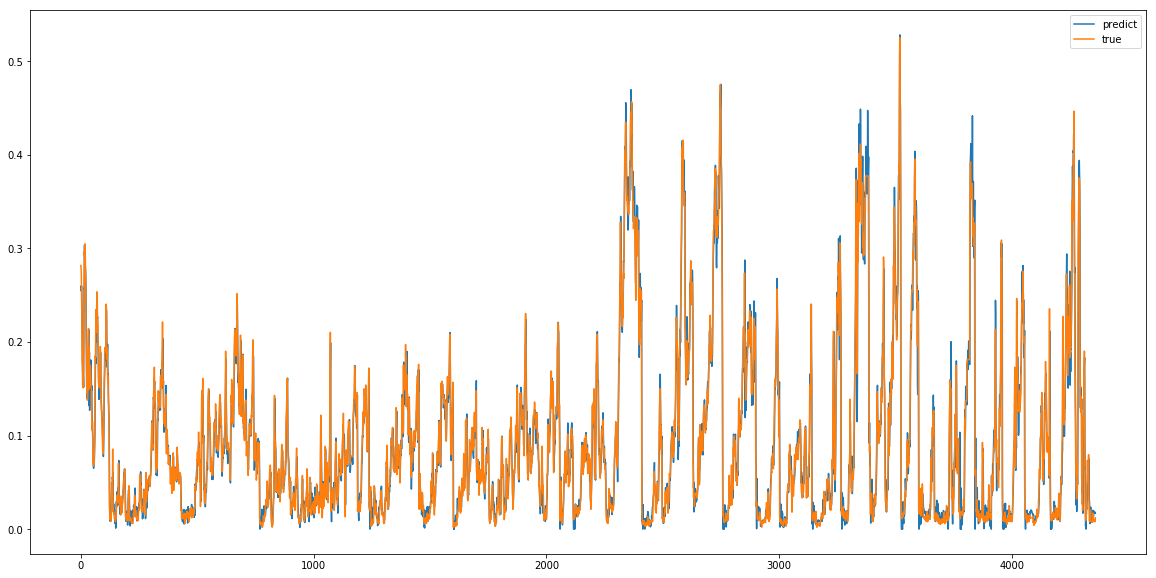

Test RMSE: 0.01985
Test MAE: 0.01248
Test MSE: 0.00039
Test RMSE: 21.55784
Test MAE: 13.55454


In [671]:
# time 1dcnn(5,3,1)

from sklearn.metrics import *

from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
mae=mean_absolute_error(yhat_inverse, testY_inverse)
print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)


### Bidirectional LSTM

In [117]:
from tensorflow.keras.models import Model

first_input = Input(shape=(24,8))

in1=Bidirectional(LSTM(85))(first_input)
in1=Dense(1,activation='relu')(in1)
model=Model(first_input,in1)
model.compile(optimizer='adam', loss='mse')
model.summary()
checkpoint_path = "saved_weights/pm2.5_timebilstm.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
# fit model
model.fit(trainX, trainY,validation_data=[valX,valY], epochs=50, verbose=1,callbacks=[cb])

Model: "functional_93"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 24, 8)]           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 170)               63920     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 171       
Total params: 64,091
Trainable params: 64,091
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1091/1095 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00001: val_loss improved from inf to 0.00000, saving model to saved_weights\pm2.5_timebilstm.hdf5
1095/1095 [==============================] - 12s 11ms/step - loss: 0.0011 - val_loss: 0.0000e+00
Epoch 2/50
1094/1095 [============================>.] - ETA: 0s - loss: 5.2512e-04
Epoch 00002: val

KeyboardInterrupt: 

In [118]:
model.load_weights("saved_weights/pm2.5_timebilstm.hdf5")

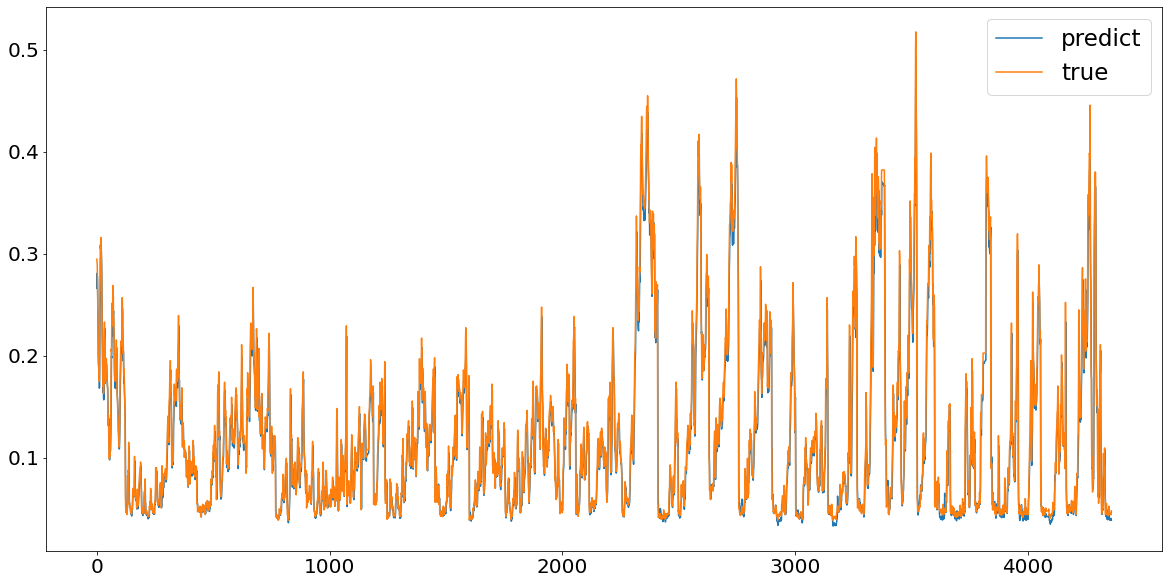

Test RMSE: 0.01797
Test MAE: 0.01113
Test MSE: 0.00032
Test MAPE: 0.09932
Test RMSE: 19.51308
Test MAE: 12.09190
Test MAPE: 0.24681


In [120]:
from sklearn.metrics import *
from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)



yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(np.array(yhat_inverse), testY_inverse))
mae=mean_absolute_error(np.array(yhat_inverse), testY_inverse)
mape=mean_absolute_percentage_error(testY_inverse,np.array(yhat_inverse))

print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)
print('Test MAPE: %.5f' % mape)


### 1d-CNN

In [127]:
first_input = Input(shape=(24,8))

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2,name='extractor')(in1)
in1=Flatten()(in1)
in1=Dense(20, activation='relu')(in1)
out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

model.summary()

checkpoint_path = "saved_weights/pm2.51.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
# fit model


Model: "functional_97"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 24, 8)]           0         
_________________________________________________________________
conv1d_78 (Conv1D)           (None, 24, 64)            1088      
_________________________________________________________________
conv1d_79 (Conv1D)           (None, 24, 64)            8256      
_________________________________________________________________
conv1d_80 (Conv1D)           (None, 24, 64)            4160      
_________________________________________________________________
conv1d_81 (Conv1D)           (None, 24, 64)            8256      
_________________________________________________________________
conv1d_82 (Conv1D)           (None, 24, 64)            8256      
_________________________________________________________________
conv1d_83 (Conv1D)           (None, 24, 64)          

In [128]:
model.fit(trainX, trainY,validation_data=[valX,valY],epochs=200, verbose=1,callbacks=[cb])

Epoch 1/200
1091/1095 [============================>.] - ETA: 0s - loss: 9.4533e-04
Epoch 00001: val_loss improved from inf to 0.00000, saving model to saved_weights\pm2.51.hdf5
1095/1095 [==============================] - 5s 4ms/step - loss: 9.4329e-04 - val_loss: 0.0000e+00
Epoch 2/200
1090/1095 [============================>.] - ETA: 0s - loss: 5.3290e-04
Epoch 00002: val_loss did not improve from 0.00000
1095/1095 [==============================] - 5s 5ms/step - loss: 5.3239e-04 - val_loss: 0.0000e+00
Epoch 3/200
1091/1095 [============================>.] - ETA: 0s - loss: 5.2377e-04
Epoch 00003: val_loss did not improve from 0.00000
1095/1095 [==============================] - 6s 5ms/step - loss: 5.2408e-04 - val_loss: 0.0000e+00
Epoch 4/200
1093/1095 [============================>.] - ETA: 0s - loss: 5.1644e-04
Epoch 00004: val_loss did not improve from 0.00000
1095/1095 [==============================] - 6s 5ms/step - loss: 5.1653e-04 - val_loss: 0.0000e+00
Epoch 5/200
1088/1095

KeyboardInterrupt: 

In [123]:
model.load_weights("saved_weights/pm2.51.hdf5")

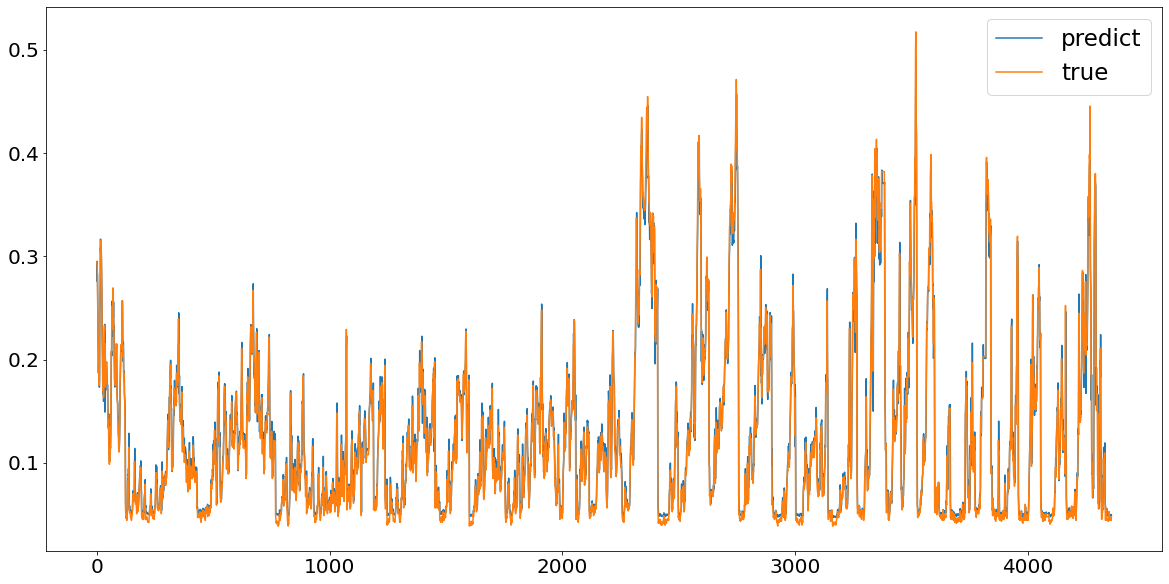

In [129]:
from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

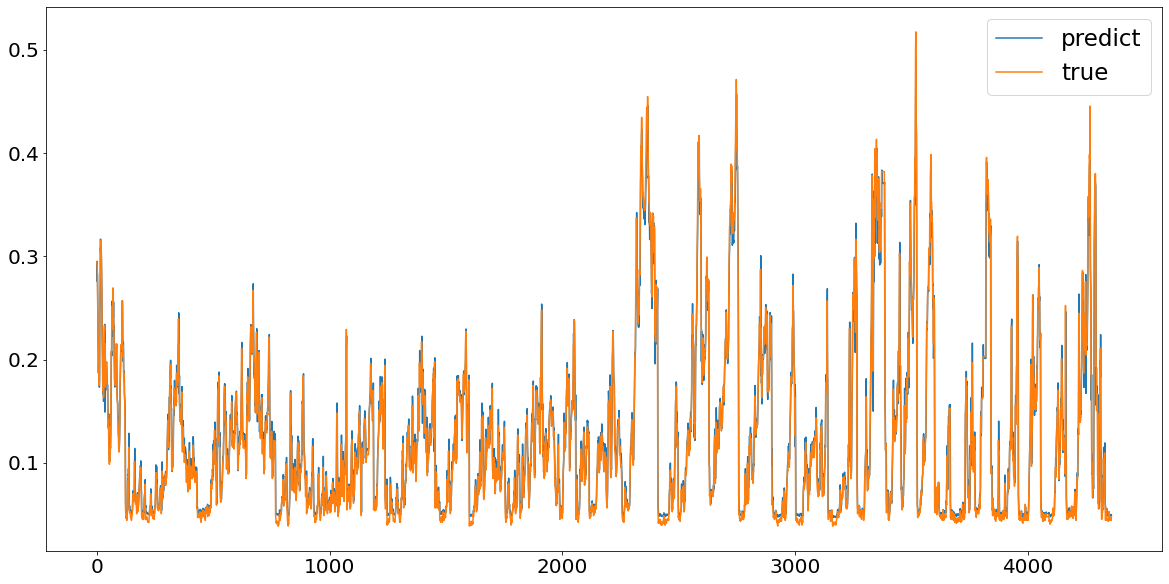

Test RMSE: 0.01678
Test MAE: 0.01013
Test MSE: 0.00028
Test MAPE: 0.09820
Test RMSE: 18.21987
Test MAE: 11.00575
Test MAPE: 0.28966


In [130]:
from sklearn.metrics import *
from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)



yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(np.array(yhat_inverse), testY_inverse))
mae=mean_absolute_error(np.array(yhat_inverse), testY_inverse)
mape=mean_absolute_percentage_error(testY_inverse,np.array(yhat_inverse))

print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)
print('Test MAPE: %.5f' % mape)


In [318]:
##1dcnn

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

Test RMSE: 0.01665
Test MAE: 0.01034


In [238]:
id_=100
X_test=testX.copy()
testX_inverse=X_test[id_][:,0]*(np.max(values)-np.min(values))+np.min(values)
testX_inverse

array([157.     , 153.     , 153.     , 149.99998, 158.     , 168.     ,
       167.     , 184.     , 194.     , 181.     , 153.     , 139.     ,
       133.     , 130.     , 116.     , 114.     ,  99.     ,  94.     ,
        84.     ,  80.     ,  80.     ,  88.     , 103.     , 132.     ],
      dtype=float32)

[0.10950363 0.3723971  0.63523    0.8027845  0.96077484 0.9937651
 0.9989709  1.         0.9994552  0.9900121  0.97548425 0.9659201
 0.96047217 0.9312954  0.8735472  0.83226395 0.8197942  0.8030872
 0.7751816  0.7716707  0.8783293  0.93286926 0.46646488 0.        ]


(-0.5, 23.5, 119.5, -0.5)

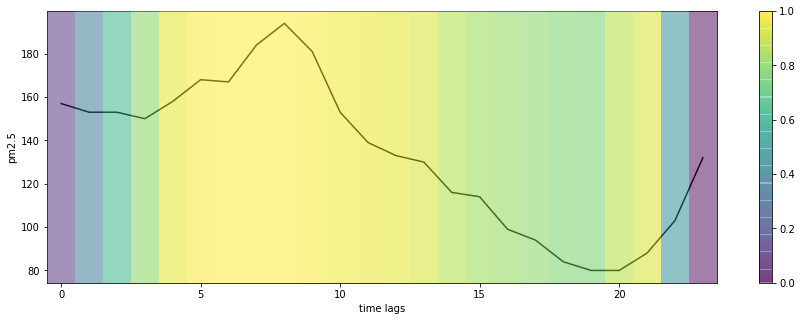

In [239]:
from scipy.ndimage import zoom
import random
import pylab




X_test=testX.copy()
activation = activation_grad(X_test[id_], model)
print(activation)
plt.figure(figsize=(15,5))
label=[0,5,10,15,20]
plt.xticks(np.arange(0,24,5),label)

plt.plot(testX_inverse, 'k')
#plt.plot(X_test[id_])
#plt.plot(yhat, label='predict')
#plt.plot(testY, label='true')
plt.ylabel('pm2.5'); plt.xlabel('time lags'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
plt.twinx()
#plt.xticks(a)
plt.imshow(np.vstack([activation]*120), alpha=0.5, cmap='viridis')
plt.axis('off'); plt.colorbar()
plt.axis('off')

### Timedistributed LSTM-CNN

In [745]:
first_input = Input(shape=(None,24,11))

in1=TimeDistributed(LSTM(units =150 , return_sequences=True))(first_input)

#in1=TimeDistributed(Conv1D(filters=64, kernel_size=2, activation='relu'))(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'))(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'))(in1)

#in1=add([in0,in1],name='extractor')
in1=TimeDistributed(MaxPooling1D(pool_size=2,name='extractor'))(in1)

in1=TimeDistributed(Flatten())(in1)
#model.add(LSTM(units = 128, return_sequences=True))
#in1=LSTM(units =50 , return_sequences=False)(in1)
#lstm_out=Bidirectional(LSTM(units =100 , return_sequences=False))(lstm_out)

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1, in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2)(in1)

#flat_out = Flatten()(in1)
#flat_out=Dense(20, activation='relu')(flat_out)
#model.add(Dropout(drop_dense))
out1=Dense(1, activation = 'relu')(in1)
model=Model(inputs=first_input, outputs=out1)
model.compile(optimizer='adam', loss='mse')




In [746]:
model.summary()

Model: "model_28151"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_125 (InputLayer)       [(None, None, 24, 11)]    0         
_________________________________________________________________
time_distributed_384 (TimeDi (None, None, 24, 150)     97200     
_________________________________________________________________
time_distributed_385 (TimeDi (None, None, 22, 64)      28864     
_________________________________________________________________
time_distributed_386 (TimeDi (None, None, 22, 64)      4160      
_________________________________________________________________
time_distributed_387 (TimeDi (None, None, 11, 64)      0         
_________________________________________________________________
time_distributed_388 (TimeDi (None, None, 704)         0         
_________________________________________________________________
dense_132 (Dense)            (None, None, 1)           

In [747]:
checkpoint_path = "saved_weights/timedistribute_pm2.5_lstmcnn_150_3_1.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

In [748]:
history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Train on 35035 samples, validate on 4358 samples
Epoch 1/200
34900/35035 [============================>.] - ETA: 0s - loss: 0.0025
Epoch 00001: val_loss improved from inf to 0.00129, saving model to saved_weights/timedistribute_pm2.5_lstmcnn_150_3_1.hdf5
35035/35035 [==============================] - 12s 334us/sample - loss: 0.0025 - val_loss: 0.0013
Epoch 2/200
34900/35035 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00002: val_loss improved from 0.00129 to 0.00098, saving model to saved_weights/timedistribute_pm2.5_lstmcnn_150_3_1.hdf5
35035/35035 [==============================] - 8s 222us/sample - loss: 0.0011 - val_loss: 9.8348e-04
Epoch 3/200
34900/35035 [============================>.] - ETA: 0s - loss: 7.8606e-04
Epoch 00003: val_loss improved from 0.00098 to 0.00070, saving model to saved_weights/timedistribute_pm2.5_lstmcnn_150_3_1.hdf5
35035/35035 [==============================] - 8s 222us/sample - loss: 7.8500e-04 - val_loss: 7.0265e-04
Epoch 4/200
34900

Epoch 33/200
34900/35035 [============================>.] - ETA: 0s - loss: 5.0438e-04
Epoch 00033: val_loss did not improve from 0.00057
35035/35035 [==============================] - 8s 222us/sample - loss: 5.0358e-04 - val_loss: 5.9479e-04
Epoch 34/200
34900/35035 [============================>.] - ETA: 0s - loss: 5.0077e-04
Epoch 00034: val_loss did not improve from 0.00057
35035/35035 [==============================] - 8s 222us/sample - loss: 5.0037e-04 - val_loss: 5.9754e-04
Epoch 35/200
34900/35035 [============================>.] - ETA: 0s - loss: 4.9350e-04
Epoch 00035: val_loss did not improve from 0.00057
35035/35035 [==============================] - 8s 222us/sample - loss: 4.9318e-04 - val_loss: 6.2706e-04
Epoch 36/200
34900/35035 [============================>.] - ETA: 0s - loss: 4.8462e-04
Epoch 00036: val_loss did not improve from 0.00057
35035/35035 [==============================] - 8s 221us/sample - loss: 4.8414e-04 - val_loss: 6.0748e-04
Epoch 37/200
34900/35035 [==

Epoch 67/200
34900/35035 [============================>.] - ETA: 0s - loss: 4.0061e-04
Epoch 00067: val_loss did not improve from 0.00057
35035/35035 [==============================] - 8s 221us/sample - loss: 4.0032e-04 - val_loss: 6.7587e-04
Epoch 68/200
34900/35035 [============================>.] - ETA: 0s - loss: 3.9725e-04
Epoch 00068: val_loss did not improve from 0.00057
35035/35035 [==============================] - 8s 222us/sample - loss: 3.9677e-04 - val_loss: 6.3896e-04
Epoch 69/200
34900/35035 [============================>.] - ETA: 0s - loss: 3.9500e-04
Epoch 00069: val_loss did not improve from 0.00057
35035/35035 [==============================] - 8s 221us/sample - loss: 3.9482e-04 - val_loss: 6.3722e-04
Epoch 70/200
34900/35035 [============================>.] - ETA: 0s - loss: 3.8710e-04
Epoch 00070: val_loss did not improve from 0.00057
35035/35035 [==============================] - 8s 221us/sample - loss: 3.8710e-04 - val_loss: 6.3130e-04
Epoch 71/200
34900/35035 [==

Epoch 101/200
34900/35035 [============================>.] - ETA: 0s - loss: 3.0023e-04
Epoch 00101: val_loss did not improve from 0.00057
35035/35035 [==============================] - 8s 222us/sample - loss: 3.0032e-04 - val_loss: 6.8575e-04
Epoch 102/200
34900/35035 [============================>.] - ETA: 0s - loss: 3.0234e-04
Epoch 00102: val_loss did not improve from 0.00057
35035/35035 [==============================] - 8s 221us/sample - loss: 3.0215e-04 - val_loss: 6.8568e-04
Epoch 103/200
34900/35035 [============================>.] - ETA: 0s - loss: 2.9850e-04
Epoch 00103: val_loss did not improve from 0.00057
35035/35035 [==============================] - 8s 221us/sample - loss: 2.9849e-04 - val_loss: 6.9050e-04
Epoch 104/200
34900/35035 [============================>.] - ETA: 0s - loss: 2.9583e-04
Epoch 00104: val_loss did not improve from 0.00057
35035/35035 [==============================] - 8s 222us/sample - loss: 2.9591e-04 - val_loss: 7.4253e-04
Epoch 105/200
34900/3503

Epoch 135/200
34900/35035 [============================>.] - ETA: 0s - loss: 2.3214e-04
Epoch 00135: val_loss did not improve from 0.00057
35035/35035 [==============================] - 8s 221us/sample - loss: 2.3212e-04 - val_loss: 7.7176e-04
Epoch 136/200
34900/35035 [============================>.] - ETA: 0s - loss: 2.2495e-04
Epoch 00136: val_loss did not improve from 0.00057
35035/35035 [==============================] - 8s 222us/sample - loss: 2.2509e-04 - val_loss: 7.7548e-04
Epoch 137/200
34900/35035 [============================>.] - ETA: 0s - loss: 2.2928e-04
Epoch 00137: val_loss did not improve from 0.00057
35035/35035 [==============================] - 8s 221us/sample - loss: 2.2957e-04 - val_loss: 7.7703e-04
Epoch 138/200
34900/35035 [============================>.] - ETA: 0s - loss: 2.2232e-04
Epoch 00138: val_loss did not improve from 0.00057
35035/35035 [==============================] - 8s 221us/sample - loss: 2.2320e-04 - val_loss: 7.7343e-04
Epoch 139/200
34900/3503

Epoch 169/200
34900/35035 [============================>.] - ETA: 0s - loss: 1.7681e-04
Epoch 00169: val_loss did not improve from 0.00057
35035/35035 [==============================] - 8s 221us/sample - loss: 1.7693e-04 - val_loss: 7.8670e-04
Epoch 170/200
34900/35035 [============================>.] - ETA: 0s - loss: 1.6890e-04
Epoch 00170: val_loss did not improve from 0.00057
35035/35035 [==============================] - 8s 222us/sample - loss: 1.6904e-04 - val_loss: 8.4811e-04
Epoch 171/200
34900/35035 [============================>.] - ETA: 0s - loss: 1.6668e-04
Epoch 00171: val_loss did not improve from 0.00057
35035/35035 [==============================] - 8s 221us/sample - loss: 1.6652e-04 - val_loss: 8.0984e-04
Epoch 172/200
34900/35035 [============================>.] - ETA: 0s - loss: 1.7098e-04
Epoch 00172: val_loss did not improve from 0.00057
35035/35035 [==============================] - 8s 221us/sample - loss: 1.7098e-04 - val_loss: 8.2017e-04
Epoch 173/200
34900/3503

In [742]:
model.load_weights("saved_weights/timedistribute_pm2.5_lstmcnn_150_3_1.hdf5")

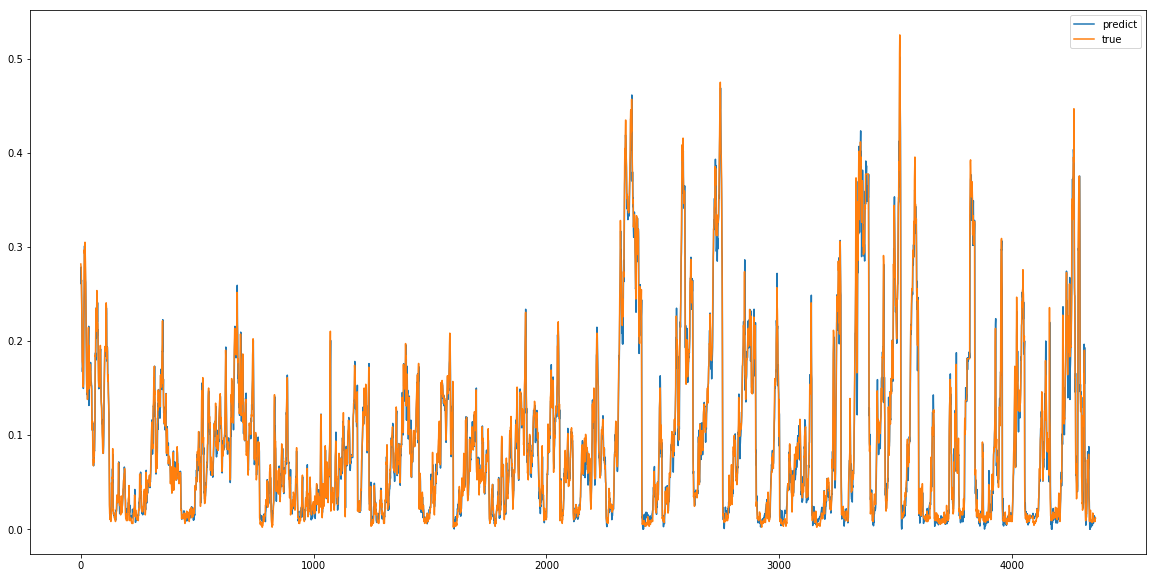

Test RMSE: 0.01806
Test MAE: 0.01101
Test MSE: 0.00033
Test RMSE: 19.61045
Test MAE: 11.95379


In [744]:
## lstm(150)-cnn(5,1),timedistribute_pm2.5_lstmcnn_150_5_11.hdf5

from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
mae=mean_absolute_error(yhat_inverse, testY_inverse)
print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae )

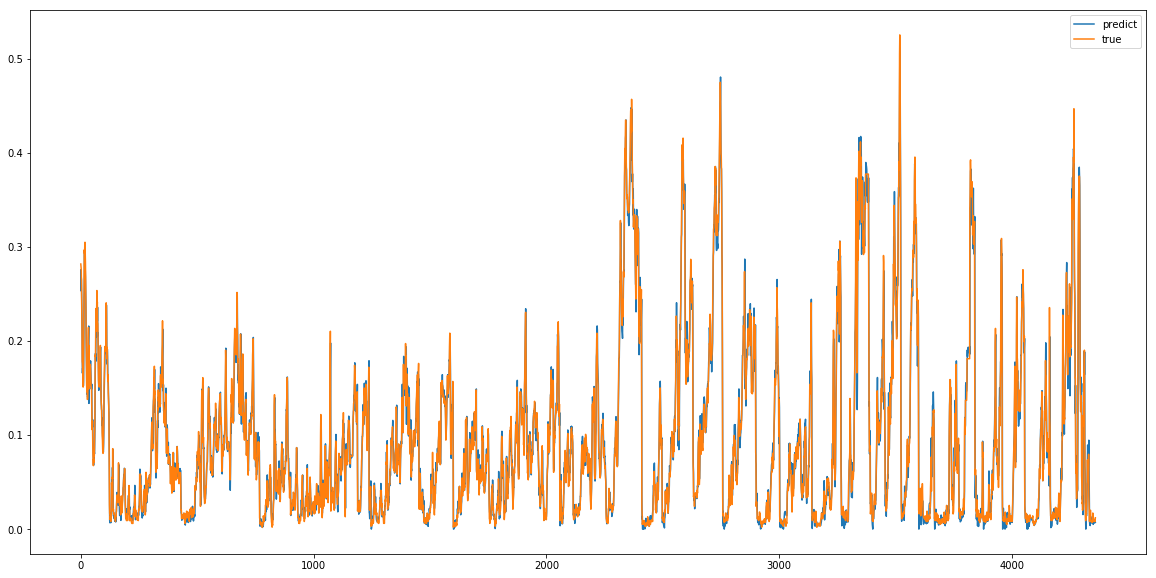

Test RMSE: 0.01770
Test MAE: 0.01071
Test MSE: 0.00031
Test RMSE: 19.21818
Test MAE: 11.63510


In [572]:
## lstm(150)-cnn(3,1)

from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
mae=mean_absolute_error(yhat_inverse, testY_inverse)
print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)


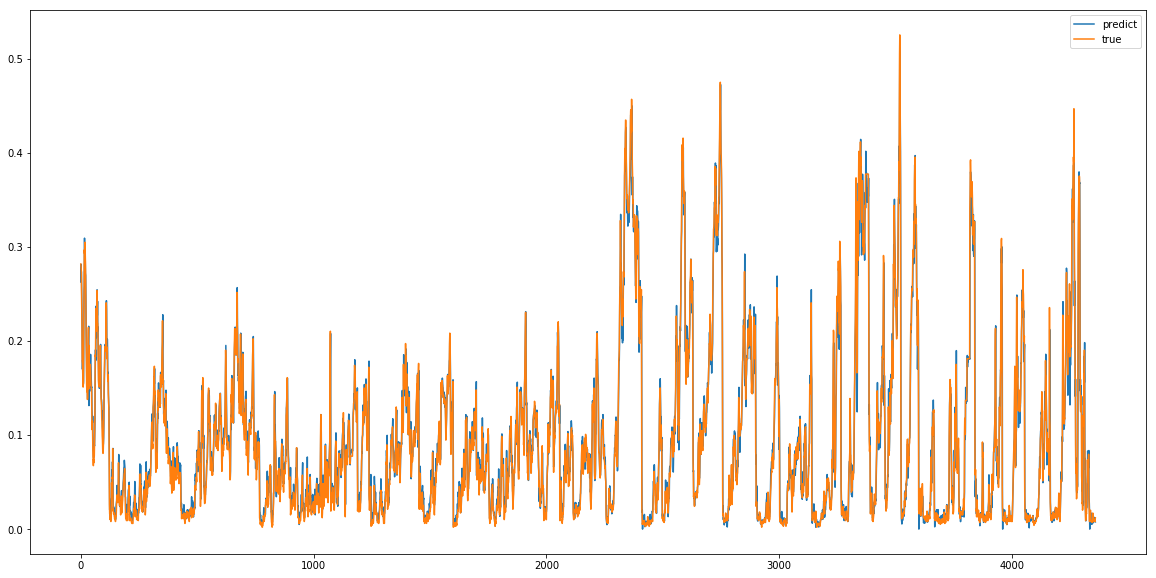

Test RMSE: 0.01783
Test MAE: 0.01091
Test MSE: 0.00032
Test RMSE: 19.36649
Test MAE: 11.85078


In [644]:
## lstm(100)-cnn(3,1)

from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)



yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
mae=mean_absolute_error(yhat_inverse, testY_inverse)
print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)

In [535]:
yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)

In [536]:
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)

In [537]:
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 19.218


In [63]:

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

### visualization

In [28]:
def gradient_importance(seq, model):

    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(seq)

    grads = tape.gradient(predictions, seq)
    grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grads



def activation_grad(seq, model):
    
    seq = seq[np.newaxis,:,:]
    grad_model = Model([model.inputs], 
                       [model.get_layer('extractor').output, 
                        model.output])

    # Obtain the predicted value and the intermediate filters
    with tf.GradientTape() as tape:
        seq_outputs, predictions = grad_model(seq)

    # Extract filters and gradients
    output = seq_outputs[0]
    grads = tape.gradient(predictions, seq_outputs)[0]

    # Average gradients spatially
    weights = tf.reduce_mean(grads, axis=0)
    
    # Get a ponderated map of filters according to grad importance
    cam = np.ones(output.shape[0], dtype=np.float32)
    for index, w in enumerate(weights):
        cam += w * output[:, index]

    time = int(seq.shape[1]/output.shape[0])
    cam = zoom(cam.numpy(), time, order=1)
    heatmap = (cam - cam.min())/(cam.max() - cam.min())
    
    return heatmap

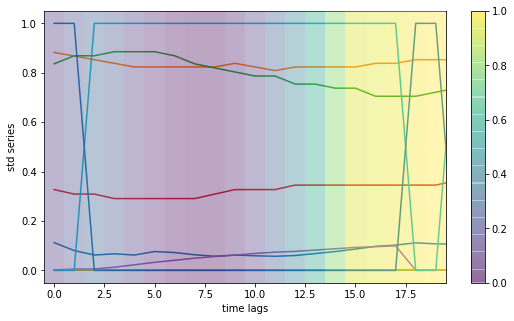

In [40]:
from scipy.ndimage import zoom
import random
id_=random.randint(0,len(testX))


X_test=testX.copy()
activation = activation_grad(X_test[id_], model)

plt.figure(figsize=(9,5))
plt.plot(X_test[id_])
#plt.plot(yhat, label='predict')
#plt.plot(testY, label='true')
plt.ylabel('std series'); plt.xlabel('time lags'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
plt.twinx()
#plt.xticks(a)
plt.imshow(np.vstack([activation]*30), alpha=0.35)
plt.axis('off'); plt.colorbar()
np.set_printoptions(False)

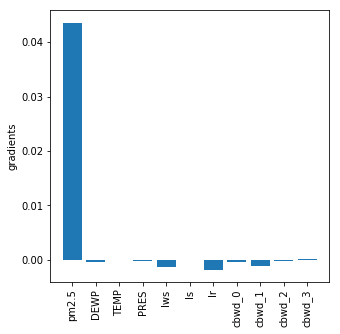

In [41]:
columns=data.columns[5:]

grad_imp = gradient_importance(X_test[id_], model)

plt.figure(figsize=(5,5))
plt.bar(range(len(grad_imp)), grad_imp)
plt.xticks(range(len(columns)), columns, rotation=90)
plt.ylabel('gradients'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
np.set_printoptions(False)

In [42]:
class CharacterTable(object):
    def __init__(self, chars):
        """Initialize character table.
        # Arguments
            chars: Characters that can appear in the input.
        """
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))

    def encode(self, C, num_rows):
        """One hot encode given string C.
        # Arguments
            num_rows: Number of rows in the returned one hot encoding. This is
                used to keep the # of rows for each data the same.
        """
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x

    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return ''.join(self.indices_char[x] for x in x)

(1, 24, 11)


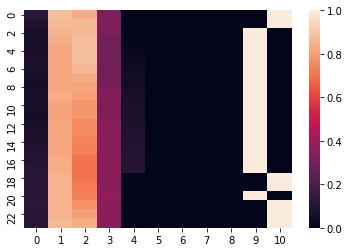

lstm_3/kernel:0 (11, 600)
[[ 0.  0.  0. ...  0. -0.  0.]
 [-0. -0. -0. ...  0. -0.  0.]
 [-0. -0. -0. ...  0. -0.  0.]
 ...
 [-0.  0. -0. ...  0.  0.  0.]
 [-0. -0.  0. ... -0. -0.  0.]
 [-0. -0.  0. ...  0. -0.  0.]]
lstm_3/recurrent_kernel:0 (150, 600)
[[-0.  0.  0. ... -0. -0.  0.]
 [ 0.  0. -0. ...  0.  0. -0.]
 [-0. -0.  0. ... -0.  0. -0.]
 ...
 [ 0. -0. -0. ...  0.  0. -0.]
 [-0. -0. -0. ...  0. -0. -0.]
 [-0.  0.  0. ...  0. -0.  0.]]
lstm_3/bias:0 (600,)
[-0. -0. -0.  0. -0. -0. -0. -0. -0. -0.  0. -0. -0. -0. -0. -0. -0. -0.
 -0.  0. -0. -0. -0. -0. -0.  0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  0. -0.  0.
 -0. -0. -0. -0. -0. -0. -0. -0.  0.  0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0.  0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  1. -0. -0.  0. -0.  0.
  0. -0. -0. -0. -0. -0. -0.  0. -0.  0. -0. -0. -0. -0. -0. -0. -0. -0.
  0. -0.  0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
  0. -0. -0. -0. -0. 

In [43]:
from tensorflow.keras.models import Model

chars = '0123456789+ '
ctable = CharacterTable(chars)
i = id_
output_final = model.predict(np.array([testX[i]]))

#print(ctable.decode(valX[i]),
 #     ctable.decode(valY[i]),
  #    ctable.decode(output_final[0]))

intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[0].output)
output = intermediate_layer_model.predict(np.array([testX[i]]))
print(output.shape)

import matplotlib.pyplot as plt
import seaborn as sns

plt.clf()
# h = np.reshape(output[0], (-1, 8))
# sns.heatmap(h)
sns.heatmap(output[0])
plt.show()

# %% Print weights.
names = [weight.name for layer in model.layers for weight in layer.weights]
weights = model.get_weights()

# suppress scientific notation
np.set_printoptions(suppress=True)
for name, weight in zip(names, weights):
    print(name, weight.shape)
    print(weight)

In [36]:
testX

array([[[0., 1., 1., ..., 0., 1., 0.],
        [0., 1., 1., ..., 0., 0., 1.],
        [0., 1., 1., ..., 0., 1., 0.],
        ...,
        [0., 1., 1., ..., 0., 1., 0.],
        [0., 1., 1., ..., 0., 1., 0.],
        [0., 1., 1., ..., 0., 1., 0.]],

       [[0., 1., 1., ..., 0., 0., 1.],
        [0., 1., 1., ..., 0., 1., 0.],
        [0., 1., 1., ..., 0., 1., 0.],
        ...,
        [0., 1., 1., ..., 0., 1., 0.],
        [0., 1., 1., ..., 0., 1., 0.],
        [0., 1., 1., ..., 0., 1., 0.]],

       [[0., 1., 1., ..., 0., 1., 0.],
        [0., 1., 1., ..., 0., 1., 0.],
        [0., 1., 1., ..., 0., 0., 1.],
        ...,
        [0., 1., 1., ..., 0., 1., 0.],
        [0., 1., 1., ..., 0., 1., 0.],
        [0., 1., 1., ..., 0., 1., 0.]],

       ...,

       [[0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0.